# XGBoost 量价策略框架

***<font color=steel
    size=5
       face=雅黑>
<mark>1. 环境准备与数据获取</mark>
</font>***

In [4]:
# 安装必要库
# pip install yfinance pandas numpy scikit-learn xgboost matplotlib seaborn ta
import shap
print(shap.__version__)
import xgboost as xgb
print(xgb.__version__)
import numpy as np
print(np.__version__)

from xtquant import xtdata
#import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 技术指标计算库
import ta

# 机器学习相关
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def fetch_stock_data(ticker, start_date, end_date):
    """
    获取股票历史数据
    """
    stock_codes = [ticker]
    fields=['open', 'close', 'high', 'low', 'volume', 'amount', 'preclose']
    xtdata.download_history_data2(stock_codes, '1d', start_date, end_date)
    data = xtdata.get_market_data_ex(field_list=fields, stock_list=stock_codes, 
                                         start_time=start_date, end_time=end_date, period='1d', 
                                         count=-1)
    stock = pd.DataFrame()
    if data and ticker in data:
        stock = data[ticker]
        print(f"成功! 数据形状: {stock.shape}, 列名: {stock.columns.tolist()}")
    else:
        print("获取失败或数据格式异常") 

    if stock.empty:
        raise ValueError(f"无法获取 {ticker} 的数据")
    
    # 重命名列以便处理
    #stock.columns = ['open', 'high', 'low', 'close', 'Adj_close', 'volume']
    
    print(f"获取到 {len(stock)} 个交易日数据")
    return stock

0.50.0
3.1.2
2.2.6


***<font color=steel
    size=5
       face=雅黑>
<mark>2. 特征工程：构建交易量与动量特征</mark>
</font>***


In [55]:
def create_features(df):
    """
    创建预测特征，包括交易量特征和动量特征
    """
    df = df.copy()
    
    # ========== 基础价格特征 ==========
    df['Returns_1d'] = df['close'].pct_change(1)  # 1日收益率
    df['Returns_5d'] = df['close'].pct_change(5)  # 5日动量（核心特征）
    df['Returns_10d'] = df['close'].pct_change(10)
    df['Returns_20d'] = df['close'].pct_change(20)
    
    # 价格位置特征
    df['high_52w'] = df['close'].rolling(window=252).max()
    df['low_52w'] = df['close'].rolling(window=252).min()
    df['Price_Position'] = (df['close'] - df['low_52w']) / (df['high_52w'] - df['low_52w'])
    
    # ========== 交易量特征（重点） ==========
    
    # 1. 基础成交量特征
    df['volume_MA_5'] = df['volume'].rolling(window=5).mean()
    df['volume_MA_20'] = df['volume'].rolling(window=20).mean()
    df['volume_Ratio_5'] = df['volume'] / df['volume_MA_5']  # 成交量比率
    df['volume_Ratio_20'] = df['volume'] / df['volume_MA_20']
    
    # 2. 资金流强度指标 (Money Flow Intensity)
    # 典型价格
    df['Typical_Price'] = (df['high'] + df['low'] + df['close']) / 3
    # 原始资金流
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['volume']
    
    # 正向资金流（上涨日）
    df['Positive_MF'] = np.where(df['close'] > df['close'].shift(1), 
                                  df['Raw_Money_Flow'], 0)
    # 负向资金流（下跌日）
    df['Negative_MF'] = np.where(df['close'] < df['close'].shift(1), 
                                  df['Raw_Money_Flow'], 0)
    
    # 计算14日资金流比率（类似MFI但简化）
    df['Positive_MF_14'] = df['Positive_MF'].rolling(window=14).sum()
    df['Negative_MF_14'] = df['Negative_MF'].rolling(window=14).sum()
    df['MF_Ratio'] = df['Positive_MF_14'] / df['Negative_MF_14']
    df['Money_Flow_Index'] = 100 - (100 / (1 + df['MF_Ratio']))
    
    # 3. 量价背离特征
    # 价格创新高但成交量未创新高（顶背离）
    df['Price_New_high'] = df['close'] == df['close'].rolling(window=20).max()
    df['volume_New_high'] = df['volume'] == df['volume'].rolling(window=20).max()
    df['volume_Price_Divergence'] = np.where(
        (df['Price_New_high'] == True) & (df['volume_New_high'] == False), 1, 0)
    
    # 4. 成交量波动率
    df['volume_Volatility'] = df['volume'].rolling(window=20).std() / df['volume_MA_20']
    
    # 5. 价量相关性（过去20日）
    df['Price_volume_Corr'] = df['close'].rolling(window=20).corr(df['volume'])
    
    # ========== 技术指标特征 ==========
    
    # 移动平均线
    df['MA_5'] = df['close'].rolling(window=5).mean()
    df['MA_20'] = df['close'].rolling(window=20).mean()
    df['MA_60'] = df['close'].rolling(window=60).mean()
    
    # 价格与均线位置
    df['Price_vs_MA5'] = (df['close'] - df['MA_5']) / df['MA_5']
    df['Price_vs_MA20'] = (df['close'] - df['MA_20']) / df['MA_20']
    df['MA5_vs_MA20'] = (df['MA_5'] - df['MA_20']) / df['MA_20']
    
    # RSI (相对强弱指数)
    df['RSI_14'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    
    # MACD
    macd = ta.trend.MACD(df['close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Diff'] = df['MACD'] - df['MACD_Signal']
    
    # 布林带
    bb = ta.volatility.BollingerBands(df['close'])
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_lower'] = bb.bollinger_lband()
    df['BB_Width'] = (df['BB_Upper'] - df['BB_lower']) / df['close']
    df['BB_Position'] = (df['close'] - df['BB_lower']) / (df['BB_Upper'] - df['BB_lower'])
    
    # ========== 波动率特征 ==========
    df['Volatility_5d'] = df['Returns_1d'].rolling(window=5).std() * np.sqrt(252)
    df['Volatility_20d'] = df['Returns_1d'].rolling(window=20).std() * np.sqrt(252)
    
    # ========== 市场情绪特征 ==========
    # 连续上涨/下跌天数
    df['Up_Days'] = (df['close'] > df['close'].shift(1)).rolling(window=5).sum()
    df['Down_Days'] = (df['close'] < df['close'].shift(1)).rolling(window=5).sum()
    
    # 价格加速度（动量的动量）
    df['Momentum_Acceleration'] = df['Returns_5d'] - df['Returns_5d'].shift(5)
    
    # ========== 目标变量：未来30天收益率 ==========
    df['Target_30d'] = df['close'].pct_change(30).rank(pct=True).shift(-30)
    #returns_rank = returns_30d.rank(pct=True)
    # 删除包含NaN的行（由于滚动计算）
    df_clean = df.dropna()
    
    print(f"特征工程完成，创建了 {df_clean.shape[1] - 1} 个特征")
    print(f"有效数据样本数: {df_clean.shape[0]}")
    
    return df_clean

***<font color=steel
    size=5
       face=雅黑>
<mark>3. 数据预处理与特征选择</mark>
</font>***


In [224]:
def prepare_data(df, test_size=0.2):
    """
    准备训练和测试数据
    """
    # 分离特征和目标
    feature_columns = [col for col in df.columns if col not in ['Target_30d', 'open', 'close', 'high', 'low', 'volume', 'amount', 'preClose']]

    # 剔除特定特征
    feature_columns = [col for col in feature_columns if col not in ['high_52w', 'low_52w', 'BB_Upper', 'BB_lower']]
    X = df[feature_columns]
    y = df['Target_30d']
    
    # 按时间顺序划分训练集和测试集（时间序列数据重要！）
    split_idx = int(len(X) * (1 - test_size))
    
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # 特征标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"训练集大小: {X_train.shape}")
    print(f"测试集大小: {X_test.shape}")
    print(f"特征数量: {X_train.shape[1]}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_columns

NameError: name 'df_with_features' is not defined

In [228]:
def diagnose_feature_engineering_issues(X, y, feature_name):
    """
    诊断特征工程问题
    """
    from scipy import stats
    import matplotlib.pyplot as plt
    
    print(f"\n=== 特征 '{feature_name}' 诊断报告 ===")
    
    # 1. 检查特征与目标的相关性
    corr_coef, p_value = stats.pearsonr(X[feature_name].fillna(0), y)
    print(f"1. 与目标变量的Pearson相关性:")
    print(f"   相关系数: {corr_coef:.6f}")
    print(f"   p-value: {p_value:.6f}")
    
    # 2. 检查特征分布
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 直方图
    axes[0, 0].hist(X[feature_name].dropna(), bins=50, alpha=0.7)
    axes[0, 0].set_title(f'特征分布: {feature_name}')
    axes[0, 0].set_xlabel('特征值')
    axes[0, 0].set_ylabel('频数')
    
    # 箱线图
    axes[0, 1].boxplot(X[feature_name].dropna())
    axes[0, 1].set_title(f'箱线图: {feature_name}')
    
    # 与目标的散点图
    axes[1, 0].scatter(X[feature_name], y, alpha=0.5, s=10)
    axes[1, 0].set_title(f'{feature_name} vs 目标变量')
    axes[1, 0].set_xlabel(feature_name)
    axes[1, 0].set_ylabel('目标变量')
    
    # QQ图检查正态性
    from scipy import stats as st
    st.probplot(X[feature_name].dropna(), dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title(f'QQ图: {feature_name}')
    
    plt.tight_layout()
    plt.show()
    
    # 3. 检查信息值 (Information Value)
    def calculate_iv(X_series, y_series, bins=10):
        """计算信息值（用于衡量特征预测能力）"""
        # 将连续特征分箱
        binned = pd.qcut(X_series, q=bins, duplicates='drop')
        
        # 统计每个箱中的好坏样本数（这里简化，假设y是二分类）
        # 对于回归问题，可以先将y离散化
        if y_series.nunique() > 2:
            y_binary = (y_series > y_series.median()).astype(int)
        else:
            y_binary = y_series
        
        iv_total = 0
        for group in binned.unique():
            if pd.isna(group):
                continue
            mask = binned == group
            good = (y_binary[mask] == 1).sum()
            bad = (y_binary[mask] == 0).sum()
            
            good_pct = good / y_binary.sum() if y_binary.sum() > 0 else 0
            bad_pct = bad / (len(y_binary) - y_binary.sum()) if (len(y_binary) - y_binary.sum()) > 0 else 0
            
            if good_pct > 0 and bad_pct > 0:
                iv_total += (good_pct - bad_pct) * np.log(good_pct / bad_pct)
        
        return iv_total
    
    try:
        iv = calculate_iv(X[feature_name].fillna(X[feature_name].median()), y)
        print(f"2. 信息值(IV): {iv:.6f}")
        if iv < 0.02:
            print("   ⚠️ 预测能力极弱 (IV < 0.02)")
        elif iv < 0.1:
            print("   ⚠️ 预测能力较弱 (IV < 0.1)")
        else:
            print("   ✅ 有一定的预测能力")
    except:
        print("2. 信息值计算失败")
    
    return corr_coef, p_value

***<font color=steel
    size=5
       face=雅黑>
<mark>4. XGBoost模型构建与训练</mark>
</font>***


In [219]:
def train_xgboost_model(X_train, y_train, X_test, y_test):
    """
    训练XGBoost回归模型
    """
    # 定义XGBoost参数
    params = {
        'objective': 'reg:squarederror',  # 回归任务
        'n_estimators': 1000,              # 树的数量
        'learning_rate': 0.1,            # 学习率
        'max_depth': 3,                   # 树的最大深度
        'min_child_weight': 1,            # 最小叶子节点样本权重和
        'subsample': 0.8,                 # 样本采样比例
        'colsample_bytree': 0.8,          # 特征采样比例
        'gamma': 0,                       # 分裂所需的最小损失减少
        'reg_alpha': 0.1,                 # L1正则化
        'reg_lambda': 1,                  # L2正则化
        'random_state': 42,
        'eval_metric': ['rmse', 'mae'],
        'early_stopping_rounds': 20,
        'n_jobs': -1                      # 使用所有CPU核心
    }
    
    # 创建模型
    model = xgb.XGBRegressor(**params)
    
    # 训练模型
    print("开始训练XGBoost模型...")
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)
    
    # 预测
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    return model, y_train_pred, y_test_pred

def evaluate_model(y_true, y_pred, dataset_name="测试集"):
    """
    评估模型性能
    """
    # 回归指标
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # 方向准确性（预测涨跌方向）
    direction_correct = np.sum((y_true > 0) == (y_pred > 0)) / len(y_true) * 100
    
    # 转换为百分比
    mse_pct = mse * 10000  # 转换为基点平方
    mae_pct = mae * 100    # 转换为百分比
    rmse_pct = rmse * 100  # 转换为百分比
    
    print(f"\n{'='*50}")
    print(f"{dataset_name} 评估结果:")
    print(f"{'='*50}")
    print(f"均方误差 (MSE): {mse_pct:.2f} 基点²")
    print(f"平均绝对误差 (MAE): {mae_pct:.2f}%")
    print(f"均方根误差 (RMSE): {rmse_pct:.2f}%")
    print(f"决定系数 (R²): {r2:.4f}")
    print(f"方向准确性: {direction_correct:.2f}%")
    
    return {
        'mse': mse, 'mae': mae, 'rmse': rmse, 
        'r2': r2, 'direction_accuracy': direction_correct
    }

***<font color=steel
    size=5
       face=雅黑>
<mark>5. 特征重要性分析与可视化</mark>
</font>***


In [203]:
def analyze_feature_importance(model, feature_names, df_with_features, X_train, y_train, top_n=20):
    """
    分析特征重要性
    """
    # 获取特征重要性
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    
    print(f"\n{'='*50}")
    print("特征重要性排名 (前20名):")
    print('='*50)
    
    for i, row in importance_df.head(top_n).iterrows():
        print(f"{i+1:2d}. {row['feature']:30s} : {row['importance']:.4f}")
    
    # 可视化特征重要性
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(top_n)
    plt.barh(range(len(top_features)), top_features['importance'][::-1])
    plt.yticks(range(len(top_features)), top_features['feature'][::-1])
    plt.xlabel('特征重要性')
    plt.title('XGBoost特征重要性排名 (前20名)')
    plt.tight_layout()
    plt.show()

    # 可视化重要特征的具体数据
    #print('top_features', top_features['feature'].tolist())
    #print(df_with_features[top_features['feature'].tolist()])
    #print(feature_names)
    
    # 计算相关性
    correlations = {}
    for feature in feature_names:  # 分析前10个重要特征
        if feature not in importance_df['feature'].head(10).tolist():
            continue
        if isinstance(X_train, pd.DataFrame):
            corr = np.corrcoef(X_train[feature], y_train)[0, 1]
        else:
            #print(feature)
            #print(X_train[:, feature_names.index(feature)])
            corr = np.corrcoef(X_train[:, feature_names.index(feature)], y_train)[0, 1]
        correlations[feature] = corr
    
    print("特征与目标相关性:")
    for feature, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
        print(f"{feature}: {corr:.4f}")
    
    # 可视化相关性与重要性
    analysis_df = pd.DataFrame({
        'feature': list(correlations.keys()),
        'correlation': list(correlations.values()),
        'importance': [importance_df[importance_df['feature']==f]['importance'].values[0] 
                       for f in correlations.keys()]
    })
    
    plt.figure(figsize=(10, 6))
    plt.scatter(analysis_df['correlation'], analysis_df['importance'])
    for i, row in analysis_df.iterrows():
        plt.annotate(row['feature'], (row['correlation'], row['importance']))
    plt.xlabel('Correlation with Target')
    plt.ylabel('Feature Importance')
    plt.title('Correlation vs Importance')
    plt.grid(True, alpha=0.3)
    plt.show()
        
    # 按特征类别分组分析
    feature_categories = {
        '动量特征': ['Returns_5d', 'Returns_10d', 'Returns_20d', 'Momentum_Acceleration'],
        '交易量特征': ['volume_Ratio_5', 'volume_Ratio_20', 'Money_Flow_Index', 
                    'volume_Price_Divergence', 'volume_Volatility', 'Price_volume_Corr'],
        '技术指标': ['RSI_14', 'MACD_Diff', 'BB_Width', 'BB_Position', 
                  'Price_vs_MA5', 'Price_vs_MA20', 'MA5_vs_MA20'],
        '波动率': ['Volatility_5d', 'Volatility_20d'],
        '市场情绪': ['Up_Days', 'Down_Days', 'Price_Position']
    }
    
    category_importance = {}
    for category, features in feature_categories.items():
        # 找出实际存在的特征
        existing_features = [f for f in features if f in importance_df['feature'].values]
        if existing_features:
            category_importance[category] = importance_df[
                importance_df['feature'].isin(existing_features)
            ]['importance'].sum()
    
    # 绘制类别重要性
    plt.figure(figsize=(10, 6))
    categories = list(category_importance.keys())
    importances = [category_importance[cat] for cat in categories]
    
    plt.pie(importances, labels=categories, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('特征类别重要性分布')
    plt.show()
    
    return importance_df, category_importance

***<font color=steel
    size=5
       face=雅黑>
<mark>5.1 SHAP特征分析</mark>
</font>***


In [206]:
def shap_analysis(model, X_train, feature_names, importance_df):
    import shap

    # 初始化SHAP解释器
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # 全局特征重要性（SHAP版）
    shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar")
    
    # 详细SHAP图（显示特征值与影响方向）
    shap.summary_plot(shap_values, X_train, feature_names=feature_names)
    
    # 对特定重要特征进行深入分析
    important_feature = importance_df.iloc[0]['feature']
    if isinstance(X_train, pd.DataFrame):
        feature_index = list(X_train.columns).index(important_feature)
    else:
        feature_index = feature_names.index(important_feature)
    
    # 该特征的依赖图
    shap.dependence_plot(
        important_feature, 
        shap_values, 
        X_train, 
        feature_names=feature_names,
        interaction_index=None  # 可以设置交互特征
    )
    
    # 查看该特征在不同样本上的SHAP值分布
    plt.figure(figsize=(10, 6))
    if isinstance(X_train, pd.DataFrame):
        shap_scatter = shap_values[:, feature_index]
        feature_values = X_train[important_feature]
    else:
        shap_scatter = shap_values[:, feature_index]
        feature_values = X_train[:, feature_index]
    
    plt.scatter(feature_values, shap_scatter, alpha=0.5)
    plt.xlabel(f'{important_feature} Value')
    plt.ylabel('SHAP Value (Impact on Prediction)')
    plt.title(f'SHAP Values for {important_feature}')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.show()

***<font color=steel
    size=5
       face=雅黑>
<mark>6. 预测结果可视化</mark>
</font>***


In [209]:
def visualize_predictions(y_true, y_pred, dates=None, title="预测结果对比"):
    """
    可视化预测结果
    """
    plt.figure(figsize=(14, 10))
    
    # 实际值 vs 预测值散点图
    plt.subplot(2, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('实际30天收益率')
    plt.ylabel('预测30天收益率')
    plt.title('实际值 vs 预测值')
    plt.grid(True, alpha=0.3)
    
    # 预测误差分布
    plt.subplot(2, 2, 2)
    errors = y_pred - y_true
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('预测误差')
    plt.ylabel('频次')
    plt.title('预测误差分布')
    plt.grid(True, alpha=0.3)

    print('y_true', y_true)
    print('y_pred', y_pred)
    
    # 时间序列对比（如果有日期）
    if dates is not None and len(dates) == len(y_true):
        plt.subplot(2, 1, 2)
        plt.plot(dates, y_true, 'b-', label='实际值', alpha=0.7, linewidth=1)
        plt.plot(dates, y_pred, 'r-', label='预测值', alpha=0.7, linewidth=1)
        plt.fill_between(dates, y_true, y_pred, alpha=0.2, color='gray')
        plt.xlabel('日期')
        plt.ylabel('30天收益率')
        plt.title('时间序列：实际值 vs 预测值')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(range(1, len(dates), 5), rotation=75)
    
    plt.tight_layout()
    plt.show()
    
    # 方向准确性分析
    correct_up = np.sum((y_true > 0) & (y_pred > 0))
    correct_down = np.sum((y_true < 0) & (y_pred < 0))
    wrong_up = np.sum((y_true > 0) & (y_pred < 0))
    wrong_down = np.sum((y_true < 0) & (y_pred > 0))
    print('实际上涨：', np.sum((y_true > 0)))
    print('实际下跌：',np.sum((y_true < 0)))
    print('预测上涨：', np.sum((y_pred > 0)))
    print('预测下跌：',np.sum((y_pred < 0)))
    print('实际下跌，预测上涨', wrong_down)
    confusion_data = [[correct_up, wrong_up], [wrong_down, correct_down]]
    confusion_df = pd.DataFrame(confusion_data, 
                                index=['实际上涨', '实际下跌'],
                                columns=['预测上涨', '预测下跌'])
    
    print("\n预测方向混淆矩阵:")
    print(confusion_df)
    
    # 计算精确率、召回率
    precision_up = correct_up / (correct_up + wrong_up) if (correct_up + wrong_up) > 0 else 0
    recall_up = correct_up / (correct_up + wrong_down) if (correct_up + wrong_down) > 0 else 0
    precision_down = correct_down / (correct_down + wrong_down) if (correct_down + wrong_down) > 0 else 0
    recall_down = correct_down / (correct_down + wrong_up) if (correct_down + wrong_up) > 0 else 0
    
    print(f"\n上涨预测精确率: {precision_up:.2%}")
    print(f"上涨预测召回率: {recall_up:.2%}")
    print(f"下跌预测精确率: {precision_down:.2%}")
    print(f"下跌预测召回率: {recall_down:.2%}")

***<font color=steel
    size=5
       face=雅黑>
<mark>7. 主程序：端到端预测流程</mark>
</font>***


In [243]:
def main_pipeline(ticker="AAPL", years_of_data=5, test_size=0.2):
    """
    完整的端到端预测流程
    """
    print("="*60)
    print(f"股票未来30天收益率预测系统")
    print(f"标的: {ticker}")
    print("="*60)
    
    # 1. 获取数据
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years_of_data*365)
    end_date = end_date.strftime('%Y%m%d')
    start_date = start_date.strftime('%Y%m%d')
    print(end_date)
    print(start_date)
    try:
        raw_data = fetch_stock_data(ticker, start_date, end_date)
    except Exception as e:
        print(f"数据获取失败: {e}")
        return None
    
    # 2. 特征工程
    print("\n1. 进行特征工程...")
    df_with_features = create_features(raw_data)
    print('BB_Upper', df_with_features['BB_Upper'].describe())
    print("="*60)
    feature_columns = [col for col in df_with_features.columns if col not in ['Target_30d', 'open', 'close', 'high', 'low', 'volume', 'amount', 'preClose']]
    X = df_with_features[feature_columns]
    y = df_with_features['Target_30d']
    feature_name = 'BB_lower'
    diagnose_feature_engineering_issues(X, y, feature_name)
    # 3. 数据准备
    print("\n2. 准备训练和测试数据...")
    X_train, X_test, y_train, y_test, scaler, feature_names = prepare_data(
        df_with_features, test_size=test_size)

    print('target describe', df_with_features['Target_30d'].describe())
    print("\n" + "*"*60)
    print(y_train)
    print("\n" + "*"*60)
    print(y_test)
    # 4. 训练模型
    print("\n3. 训练XGBoost模型...")
    model, y_train_pred, y_test_pred = train_xgboost_model(
        X_train, y_train, X_test, y_test)
    usage = analyze_tree_usage(model, 'BB_lower', feature_names)
    
    print(usage)
    # 5. 评估模型
    print("\n4. 评估模型性能...")
    train_metrics = evaluate_model(y_train, y_train_pred, "训练集")
    test_metrics = evaluate_model(y_test, y_test_pred, "测试集")
    
    # 6. 特征重要性分析
    print("\n5. 分析特征重要性...")
    importance_df, category_importance = analyze_feature_importance(
        model, feature_names, df_with_features, X_train, y_train)
    
    shap_analysis(model, X_train, feature_names, importance_df)
    # 7. 可视化结果
    print("\n6. 可视化预测结果...")
    test_dates = df_with_features.index[-len(y_test):]
    visualize_predictions(y_test, y_test_pred, test_dates)
    
    # 8. 生成预测报告
    print("\n" + "="*60)
    print("预测报告摘要")
    print("="*60)
    
    # 找出最重要的特征
    top_features = importance_df.head(5)['feature'].tolist()
    
    print(f"\n🔍 关键发现:")
    print(f"1. 最重要的5个特征: {', '.join(top_features)}")
    
    # 检查5日动量特征的重要性
    momentum_rank = importance_df[importance_df['feature'] == 'Returns_5d'].index
    if not momentum_rank.empty:
        rank = momentum_rank[0] + 1
        print(f"2. '5日动量'特征重要性排名: 第{rank}位")
    
    # 检查资金流特征的重要性
    mfi_rank = importance_df[importance_df['feature'] == 'Money_Flow_Index'].index
    if not mfi_rank.empty:
        rank = mfi_rank[0] + 1
        print(f"3. '资金流指数'特征重要性排名: 第{rank}位")
    
    print(f"\n📈 模型表现:")
    print(f"测试集方向准确性: {test_metrics['direction_accuracy']:.1f}%")
    print(f"测试集R²分数: {test_metrics['r2']:.4f}")
    
    # 判断模型实用性
    if test_metrics['direction_accuracy'] > 55:
        print(f"\n✅ 模型显示出一定的预测能力")
        if test_metrics['direction_accuracy'] > 60:
            print("   预测能力较强，可考虑用于辅助决策")
    else:
        print(f"\n⚠️  模型预测能力有限，建议进一步优化")
    
    return {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names,
        'importance_df': importance_df,
        'test_metrics': test_metrics,
        'predictions': y_test_pred,
        'actuals': y_test
    }

In [245]:
def analyze_tree_usage(model, feature_name, feature_names):
    """
    分析特征在决策树中的使用情况
    """
    # 获取所有树
    booster = model.get_booster()
    
    # 获取树的结构信息
    trees_dump = booster.get_dump()
    
    # 统计特征在树中的出现次数
    feature_usage = {name: 0 for name in feature_names}
    
    for tree in trees_dump:
        # 查找特征在树分裂节点中的使用
        lines = tree.split('\n')
        for line in lines:
            if 'f' in line and '[' in line:  # 分裂节点
                # 提取特征索引，如 f0, f1 等
                import re
                match = re.search(r'f(\d+)<', line)
                if match:
                    f_idx = int(match.group(1))
                    if f_idx < len(feature_names):
                        feature_name_used = feature_names[f_idx]
                        feature_usage[feature_name_used] += 1
    
    print(f"特征在树分裂节点中的使用次数:")
    for feat, count in sorted(feature_usage.items(), key=lambda x: x[1], reverse=True):
        if count > 0 or feat == feature_name:
            print(f"  {feat}: {count}次")
    
    return feature_usage

# 分析问题特征
# usage = analyze_tree_usage(model, problematic_features[0], feature_names)

***<font color=steel
    size=5
       face=雅黑>
<mark>8. 使用示例与模型部署</mark>
</font>***


股票未来30天收益率预测系统
标的: 510310.SH
20251214
20201215
成功! 数据形状: (1212, 7), 列名: ['open', 'high', 'low', 'close', 'volume', 'amount', 'preClose']
获取到 1212 个交易日数据

1. 进行特征工程...
特征工程完成，创建了 50 个特征
有效数据样本数: 931
BB_Upper count    931.000000
mean       2.544216
std        1.015595
min        1.633696
25%        1.843293
50%        1.985374
75%        3.858111
max        5.202439
Name: BB_Upper, dtype: float64

=== 特征 'BB_lower' 诊断报告 ===
1. 与目标变量的Pearson相关性:
   相关系数: 0.166984
   p-value: 0.000000


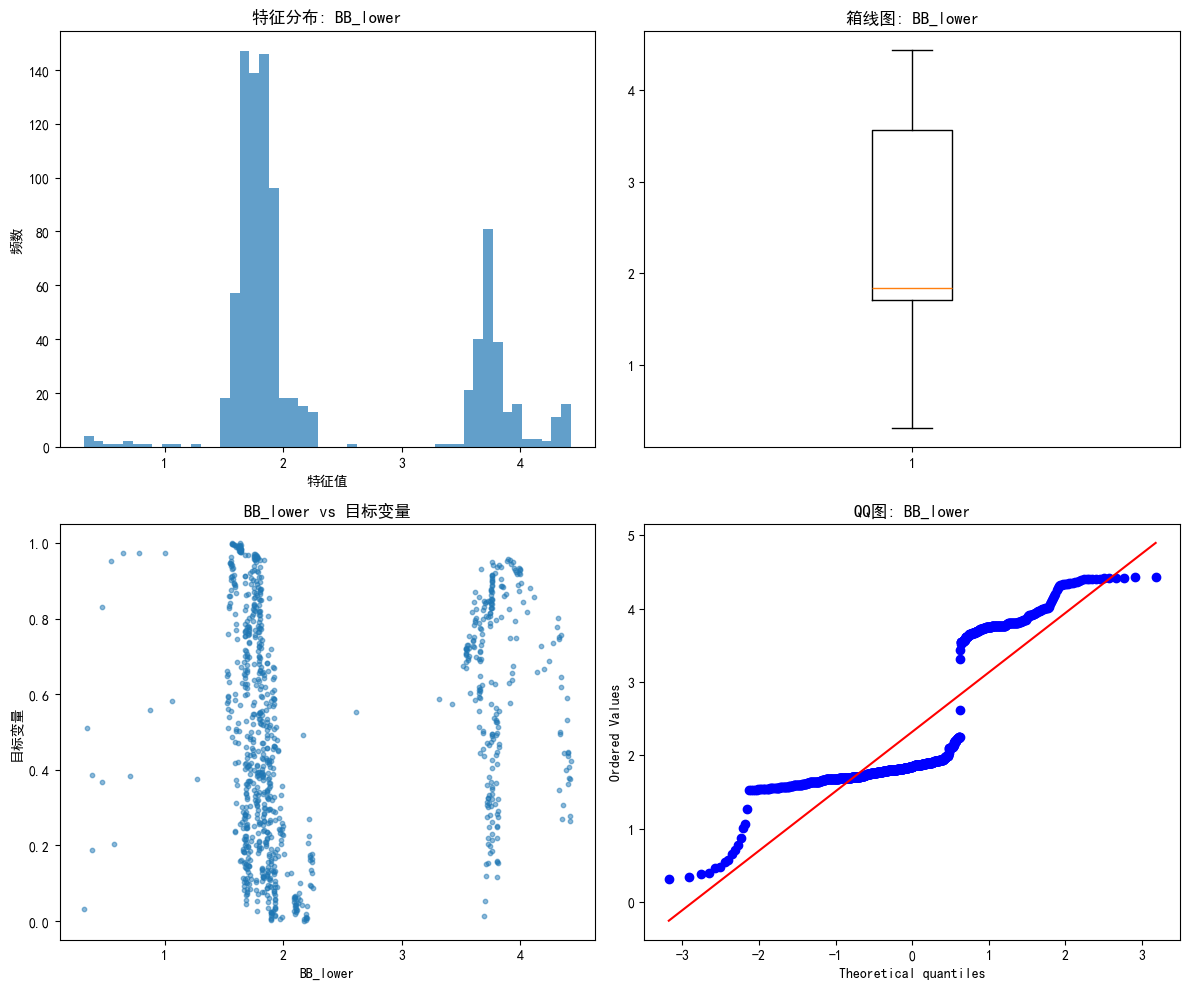

2. 信息值(IV): 0.695944
   ✅ 有一定的预测能力

2. 准备训练和测试数据...
训练集大小: (744, 39)
测试集大小: (187, 39)
特征数量: 39
target describe count    931.000000
mean       0.506980
std        0.295274
min        0.000846
25%        0.250000
50%        0.496616
75%        0.775381
max        1.000000
Name: Target_30d, dtype: float64

************************************************************
20211227    0.096447
20211228    0.093909
20211229    0.163283
20211230    0.154822
20211231    0.126904
              ...   
20250114    0.697970
20250115    0.795262
20250116    0.782572
20250117    0.752115
20250120    0.740271
Name: Target_30d, Length: 744, dtype: float64

************************************************************
20250121    0.727580
20250122    0.741963
20250123    0.842640
20250124    0.791032
20250127    0.824027
              ...   
20251027    0.377327
20251028    0.374788
20251029    0.265651
20251030    0.278342
20251031    0.422166
Name: Target_30d, Length: 187, dtype: float64

3. 训练XGBoost模型...

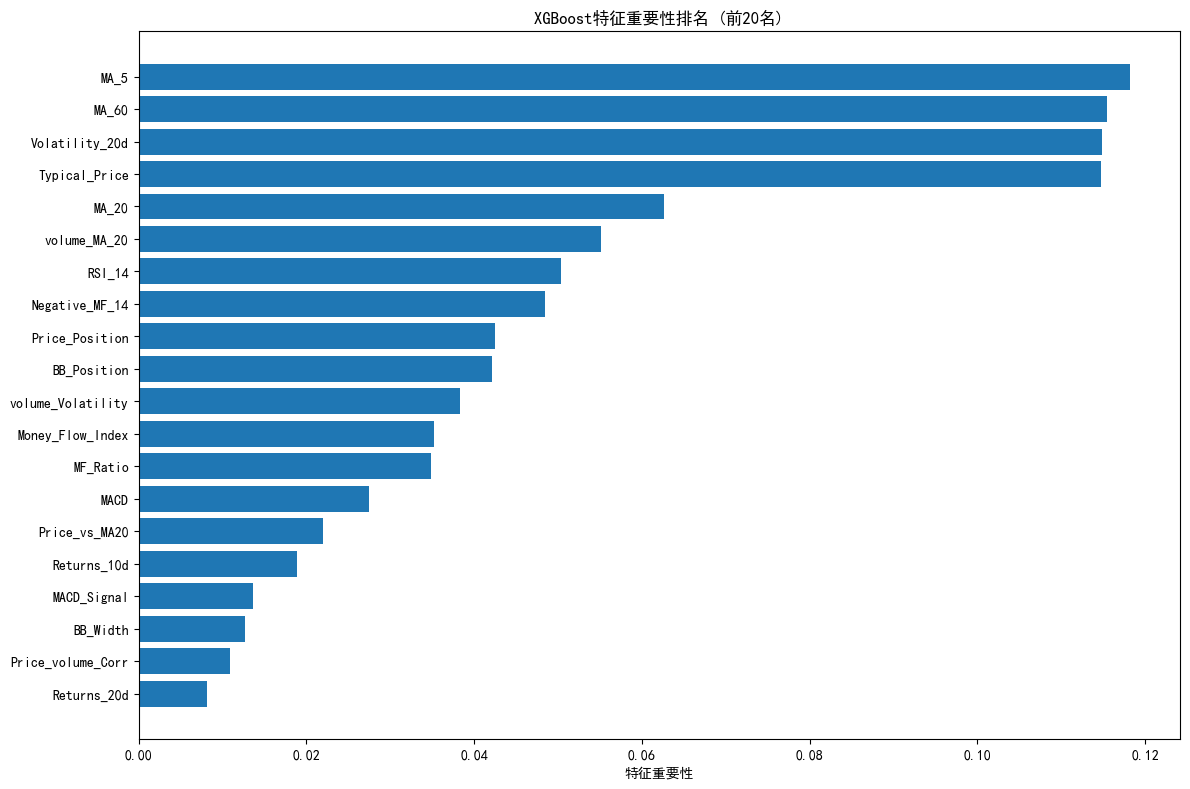

特征与目标相关性:
volume_MA_20: 0.3031
Negative_MF_14: 0.3007
Price_Position: -0.1185
MA_60: -0.1078
MA_20: -0.0995
MA_5: -0.0925
Typical_Price: -0.0807
Volatility_20d: 0.0683
RSI_14: -0.0240
BB_Position: -0.0098


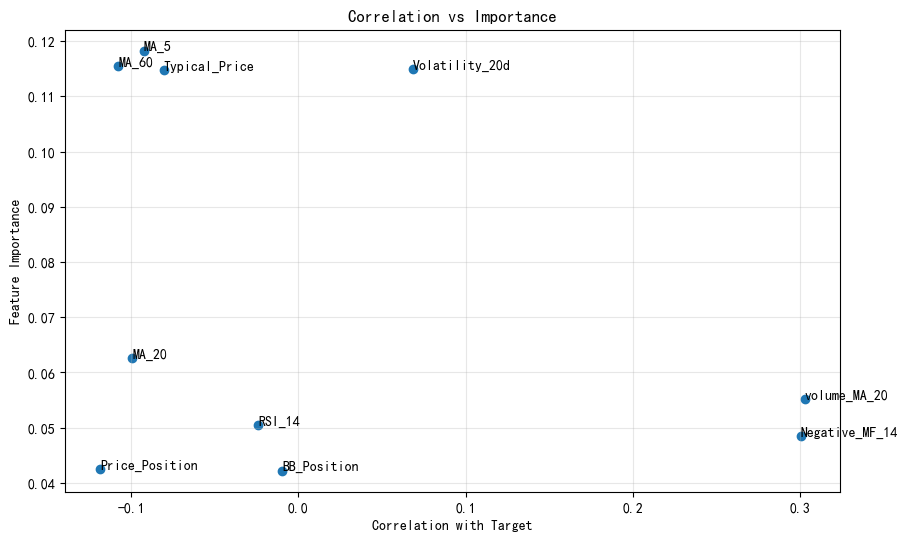

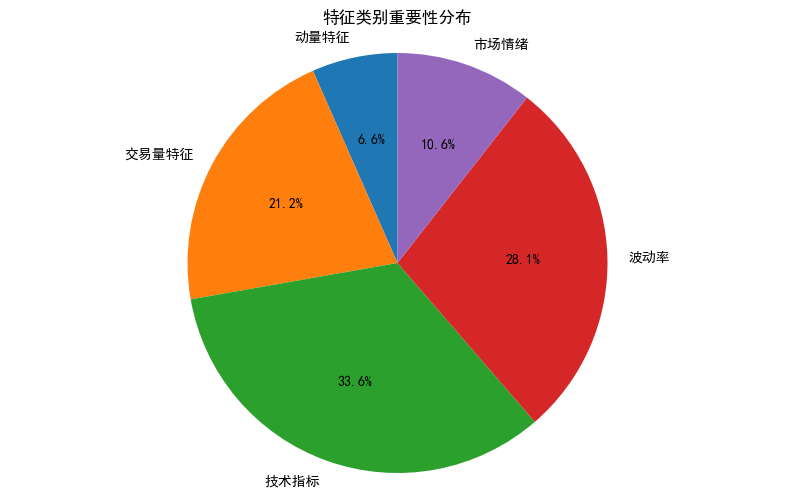

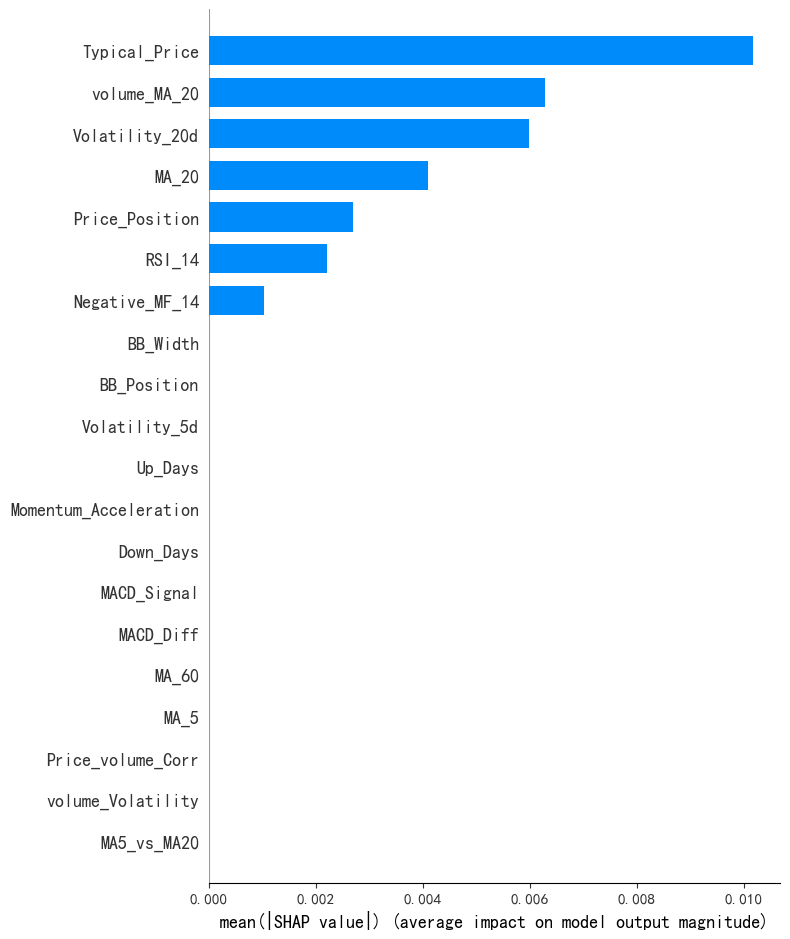

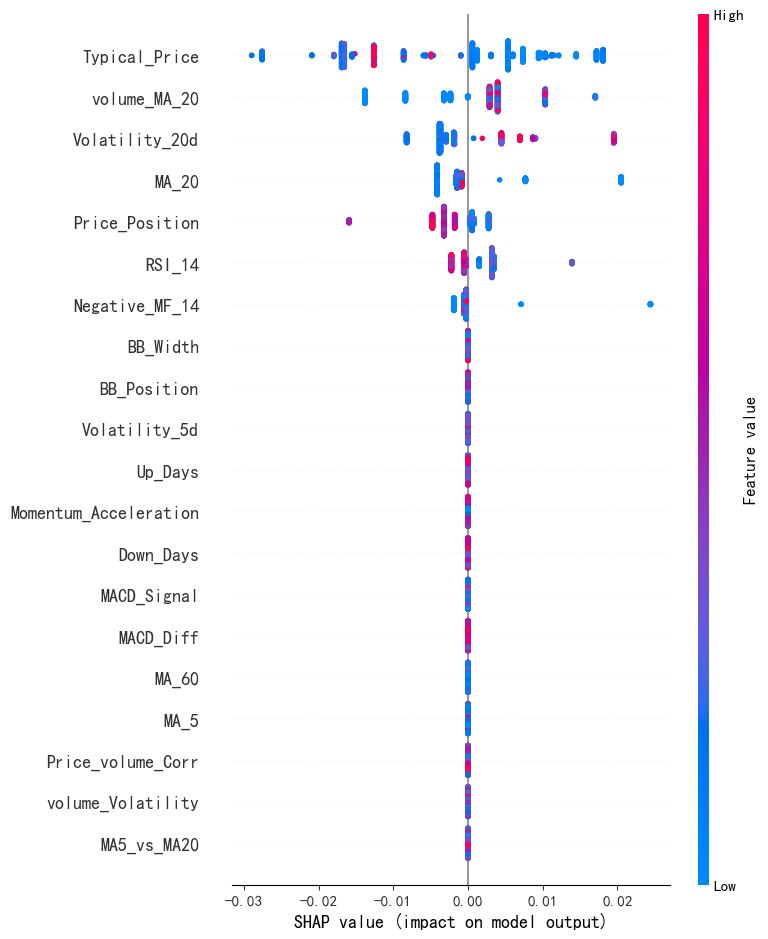

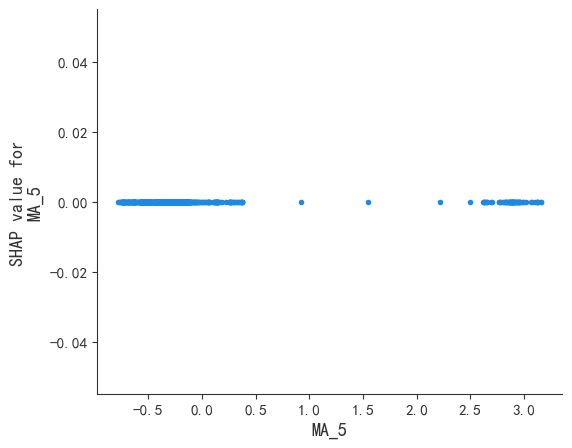

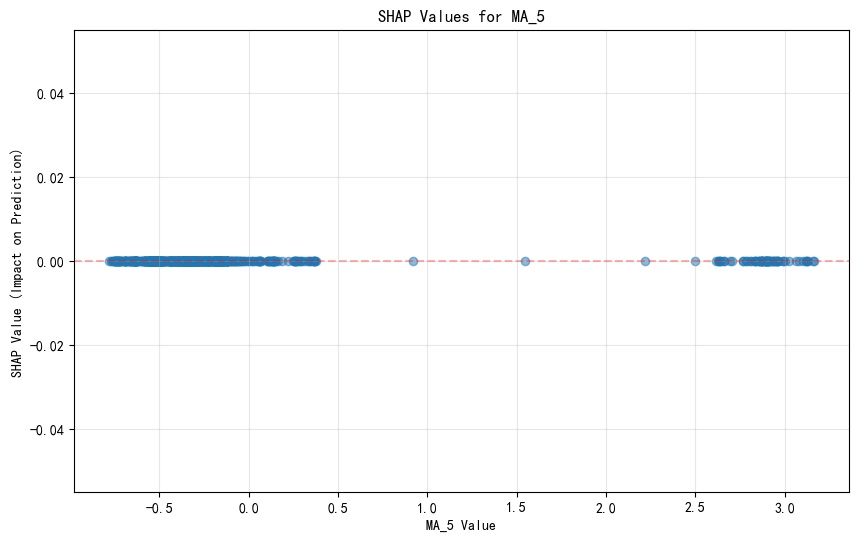


6. 可视化预测结果...
y_true 20250121    0.727580
20250122    0.741963
20250123    0.842640
20250124    0.791032
20250127    0.824027
              ...   
20251027    0.377327
20251028    0.374788
20251029    0.265651
20251030    0.278342
20251031    0.422166
Name: Target_30d, Length: 187, dtype: float64
y_pred [0.46059802 0.4911     0.4911     0.46059802 0.46059802 0.4911
 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802
 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802
 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802
 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802
 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802
 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802 0.46059802
 0.46059802 0.4911     0.4911     0.4911     0.4911     0.4911
 0.4911     0.4911     0.4911     0.4911     0.4911     0.4911
 0.4911     0.4911     0.4911     0.4911     0.46059802 0.46059802
 0.46059802 0.46059802 0.4911     0.

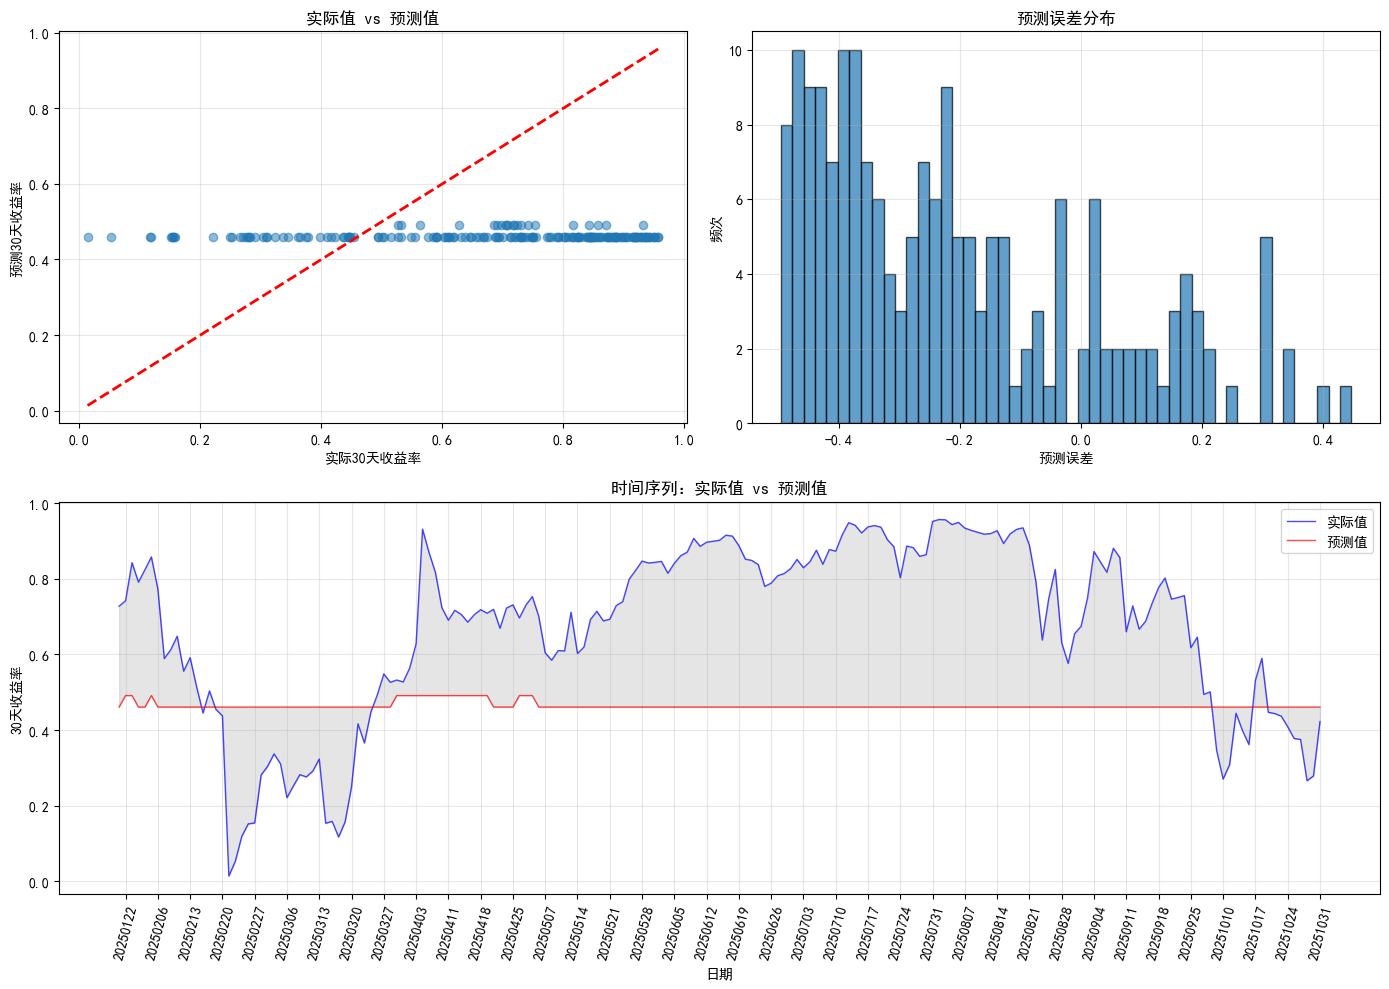

实际上涨： 187
实际下跌： 0
预测上涨： 187
预测下跌： 0
实际下跌，预测上涨 0

预测方向混淆矩阵:
      预测上涨  预测下跌
实际上涨   187     0
实际下跌     0     0

上涨预测精确率: 100.00%
上涨预测召回率: 100.00%
下跌预测精确率: 0.00%
下跌预测召回率: 0.00%

预测报告摘要

🔍 关键发现:
1. 最重要的5个特征: MA_5, MA_60, Volatility_20d, Typical_Price, MA_20
2. '5日动量'特征重要性排名: 第27位
3. '资金流指数'特征重要性排名: 第12位

📈 模型表现:
测试集方向准确性: 100.0%
测试集R²分数: -0.7809

✅ 模型显示出一定的预测能力
   预测能力较强，可考虑用于辅助决策


In [248]:
# ========== 使用示例 ==========
if __name__ == "__main__":
    # 示例1：分析苹果股票
    results = main_pipeline(ticker="510310.SH", years_of_data=5, test_size=0.2)
    
    # 示例2：批量分析多只股票
    # tickers = ["MSFT", "GOOGL", "AMZN", "TSLA"]
    # all_results = {}
    # for ticker in tickers:
    #     print(f"\n{'='*60}")
    #     print(f"分析 {ticker}")
    #     print('='*60)
    #     try:
    #         all_results[ticker] = main_pipeline(ticker=ticker, years_of_data=3, test_size=0.2)
    #     except Exception as e:
    #         print(f"分析{ticker}时出错: {e}")
    
    # 示例3：使用训练好的模型进行单点预测
    def predict_single_point(model, scaler, recent_data, feature_names):
        """
        使用训练好的模型进行单点预测
        recent_data: 包含最近60个交易日数据的DataFrame
        """
        # 创建特征
        df_features = create_features(recent_data)
        
        if len(df_features) == 0:
            return None
        
        # 获取最新数据点
        latest_features = df_features.iloc[-1:][feature_names]
        
        # 标准化
        latest_scaled = scaler.transform(latest_features)
        
        # 预测
        prediction = model.predict(latest_scaled)[0]
        
        print(f"\n预测未来30天收益率: {prediction*100:.2f}%")
        if prediction > 0:
            print("预测方向: 上涨 📈")
        else:
            print("预测方向: 下跌 📉")
        
        return prediction

In [38]:
test = 1